# 第2章 自然言語と単語の分散表現

## 2.1 自然言語処理とは

### 2.1.1 単語の意味

自然言語をコンピュータに理解させるためには，単語の意味を理解させることが重要である．


## 2.2 シソーラス

自然言語の歴史を振り返ると，単語の意味を人手で定義する試みが行われてきた．
ただし，広辞苑のように人が使う一般的な辞書ではなく，シソーラス（thesaurus）と呼ばれるタイプの辞書である．
シソーラスとは
* 類義語辞書
* 単語間で，上位と下位，全体と部分などの細かい関連性
* 単語間の関係をグラフで表す

### 2.2.1 WordNet
1985年に開発がスタート．
プリンストン大学で開発されたシソーラスである．

### 2.2.2 シソーラスの問題点
時代の変化に対応するのが困難
* 時とともに新しい単語が生まれ，古い単語は忘れられる
* 時代によって言葉の意味が変化することもある
人の作業コストが高い
* 現存する英単語の総数は1000万語以上
* Wordnetですら20万後程度
単語の細かなニュアンスを表現できない

人手で定義する手法の代わりにカウントベースの手法を次節で紹介する．

## 2.3 カウントベースの手法

カウントベース手法において，コーパスを使う
* コーパス(corpus)とは，言語の使用例を集めたデータセット


### 2.3.1 Pythonによるコーパスの下準備
pythonを用いてコーパスを準備する．

In [2]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print("Corpus:", corpus)
print("Word to ID:", word_to_id)
print("ID to Word:", id_to_word)

Corpus: [0 1 2 3 4 1 5 6]
Word to ID: {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
ID to Word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 2.3.2 単語の分散表現
色には固有の名前がつけられている（コバルトブルー，シングレッド）
一方で，RGBのように色を数値で表現することもできる．
ここで注目したい点は，RGBのようなベクトル表現の方が正確に色を指定することができるという点である．
同様に，単語の意味をベクトルで表現することができないか？

これから目指すべき場所は，単語の意味を的確に捉えたベクトル表現である．
このようなベクトル表現を単語の分散表現と呼ぶ

### 2.3.3 分布仮説
分布仮説(distributional hypothesis)とは
* 単語の意味は，周囲の単語によって形成されるというもの

コンテキストとは
* ある中央の単語に対して，その周囲にある単語を指す
* コンテキストのサイズをwindow sizeと呼ぶ

### 2.3.4 共起行列
分布仮説に基づいて，単語をベクトルで表す方法を考える．
そのための素直な方法は，周囲の単語をカウントすることである．
* カウントベースの手法を統計的手法ということもある．

すべての単語に対して，コンテキストとして共起する単語をテーブルにまとめたものを共起行列(co-occurrence matrix)と呼ぶ．

以下にpythonでの実装例を示す．


In [3]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size, window_size=1)
print("Co-occurrence Matrix:\n", co_matrix)

Co-occurrence Matrix:
 [[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### 2.3.5 ベクトル間の類似度
ベクトル間の類似度を計算する方法として，コサイン類似度(cosine similarity)がある．
コサイン類似度は$\mathbf{x} = (x_1, x_2, \ldots, x_n)$と$\mathbf{y} = (y_1, y_2, \ldots, y_n)$の間の角度を計算するもので，次のように定義される．

$$
\text{similarity}(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x} \cdot \mathbf{y}}{||\mathbf{x}|| \cdot ||\mathbf{y}||} = \frac{x_1 y_1 + x_2 y_2 + \ldots + x_n y_n}{\sqrt{x_1^2 + x_2^2 + \ldots + x_n^2} \cdot \sqrt{y_1^2 + y_2^2 + \ldots + y_n^2}}
$$

ここで，$\mathbf{x} \cdot \mathbf{y}$は内積，$||\mathbf{x}||$はベクトルのノルム（大きさ）である．
実装は以下のようになる．

```python
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x ** 2)) #xを正規化
    ny = y / np.sqrt(np.sum(y ** 2)) #yを正規化
    return np.dot(nx, ny)
```

この実装には問題がある．それはゼロベクトルが含まれている場合に，ゼロ除算が発生する可能性があることである．
これに対する常套手段は除算をする際に小さな値を足すことである．
以下のように修正する．
```python
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps) #xを正規化
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps) #yを正規化
    return np.dot(nx, ny)
```

この関数を用いると，単語ベクトルの類似度は次のように表される．ここではyouとIの類似度を計算する．

In [5]:

def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  #「you」の単語ベクトル
c1 = C[word_to_id['i']]  #「i」の単語ベクトル
print(cos_similarity(c0, c1))


0.7071067691154799


### 2.3.6 類似単語のランキング表示

コサイン類似度の実装が完了したので，その関数を用いて別の便利な関数を実装する．それは，ある単語がクエリとして与えられたときにそのクエリに対して類似した単語を上位から順に表示する関数である．
以下のようにmost_similar関数を実装する．

In [11]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
most_similar('you', word_to_id, id_to_word, C, top=5)
most_similar('i', word_to_id, id_to_word, C, top=5)

# argsortの使い方を実践
print("\nArgsortの例:")
x = np.array([300, 100,40, 200])
print("Original array:", x)
print("sorted indices:", x.argsort())
print("sorted indices (descending):", (-x).argsort())





[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0

[query] i
 goodbye: 0.9999999858578643
 you: 0.7071067691154799
 hello: 0.49999999292893216
 say: 0.0
 and: 0.0

Argsortの例:
Original array: [300 100  40 200]
sorted indices: [2 1 3 0]
sorted indices (descending): [0 3 1 2]


上の結果では，youとIの類似度が高いのは，人称代名詞だから納得できる．しかし，goodbyeやhelloのコサイン類似度の値が高いのは感覚と大きなズレがある．この理由はコーパスが小さいからである．
次節では，カウントベースの手法の改善について説明する．

## 2.4 カウントベースの手法の改善

### 2.4.1 相互情報量
これまでの共起行列において，以下の問題がある．
* theとcarの単語の共起を考える．
* the carというフレーズは多く見られると予想される．
* carとdriveという単語には明らかに強い関連性がある．
* しかし，単に出現回数だけを考えると，carとdriveの関連性はtheとcarの関連性よりも低くなる可能性がある．
* これは，theのような頻出単語が存在するためである．
この問題を解決するために，相互情報量(point wise mutual information, PMI)を用いる．
相互情報量は次のように定義される．
$$\text{PMI}(x, y) = \log _2 \frac{P(x, y)}{P(x) P(y)}$$
ここで，$P(x, y) $は単語xとyが同時に出現する確率，$P(x)$は単語xが出現する確率，$P(y)$は単語yが出現する確率である．
例えば，10000この単語からなるコーパスで，theという単語が100回出現したとする．
このとき，$P(\text{the}) = 100 / 10000 = 0.01$となる．
theとcarが10回共起したとすると，$P(\text{the,car}) = 10 / 10000 = 0.001$となる．
先ほどのPMIの式を変形する．共起行列を$C$とする，
$$\text{PMI}(x, y) = \log _2 \frac{\frac{C(x, y)}{N}}{\frac{C(x)}{N} \cdot \frac{C(y)}{N}} = \log _2 \frac{C(x, y) \times N}{C(x) C(y)}$$
ここで，$C(x, y)$は単語xとyの共起回数，$C(x)$は単語xの出現回数，$C(y)$は単語yの出現回数である．
この式を用いて，PMIを計算することができる．しかし，２つの単語で共起する回数が0の時，logが定義できない，それに対応するため，正の相互情報量(positive PMI, PPMI)を用いる．
$$\text{PPMI}(x, y) = \max(0, \text{PMI}(x, y))$$

単語xとyの共起する回数を$C(x, y)$とし，単語xの出現回数を$C(x)$，単語yの出現回数を$C(y)$とした時に，$C(x) = \Sigma _ i C(i, x)$，$C(y) = \Sigma _ i C(i, y)$，$N = \Sigma _ i  \Sigma _ j C(i, j)$とする．実装例を下に示す．

In [13]:

def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
print("word_to_id:", word_to_id)
np.set_printoptions(precision=3)  # 有効桁３桁で表示
print('co-occurrence matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

word_to_id: {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
co-occurrence matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


しかし，PPMI行列にも問題がある．
* PPMI行列は疎な行列である．ーつまり，ほとんどの要素は重要ではない
* 語彙数が増えると，PPMI行列のサイズは指数的に増加する．

### 2.4.2 次元削減
特異値分解を用いて次元削減を行う．
数式を下に書く
$$C = U \Sigma V^T$$
ここで，$C$はPPMI行列，$U$は左特異ベクトル，$\Sigma$は特異値，$V$は右特異ベクトルである．
$U$は直行行列で，単語空間を表す．
$\Sigma$は対角行列で，特異値を含む．
$V$は直行行列で，コンテキスト空間を表す
特異値が小さいほど，重要度が低いので，行列$U$から特異値が小さい列を削除することで次元削減を行う．
行列$C$の各行には，対応する単語IDの単語ベクトルが格納されており，それらの単語ベクトルが行列$U'$の行に格納される．

### 2.4.3 SVDによる次元削減
pythonで実装を行う．


Co-occurrence matrix:
 [0 1 0 0 0 0 0]
PPMI matrix:
 [0.    1.807 0.    0.    0.    0.    0.   ]
Left singular vectors (U):
 [-1.110e-16  3.409e-01 -1.205e-01 -3.886e-16  0.000e+00 -9.323e-01
  8.768e-17]


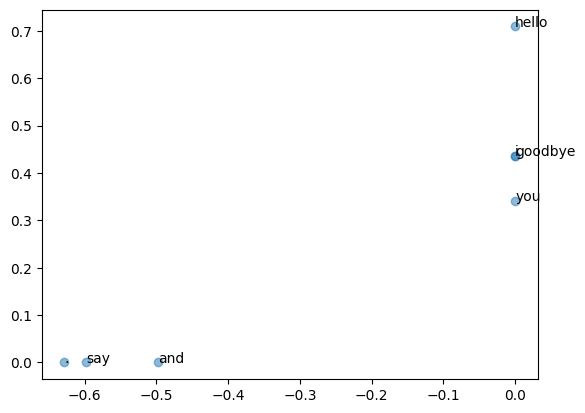

In [17]:
import matplotlib.pyplot as plt
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print("Co-occurrence matrix:\n", C[0])
print("PPMI matrix:\n", W[0])
print("Left singular vectors (U):\n", U[0])

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()


### 2.4.4 PTBデータセット
本格的なコーパスを利用する．それはPenn Treebank（PTB）データセットである．
元となるPTBに対して，いくつかの前処理を行う．例えば，レアな単語をunk(unknown)と置き換えたり，具体的な数字をN(num)で置き換えされたりしている．PTBコーパスでは，一つの文が一行ごとに保存されており，各文を連結したものを「一つの大きな時系列データ」として扱う

In [18]:
import sys
sys.path.append('../deep-learning-from-scratch-2')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])


Done
Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### 2.4.5 PTBデータセットでの評価
sklearnのrandomized_svdを用いて，PTBデータセットの単語ベクトルを計算する．特異値の大きいものだけに限定して計算することで，通常のsvdよりも高速に計算を行う．

In [19]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...
calculating PPMI ...
1.0% done
1.0% done
2.0% done
2.0% done
3.0% done
3.0% done
4.0% done
4.0% done
5.0% done
5.0% done
6.0% done
6.0% done
7.0% done
7.0% done
8.0% done
8.0% done
9.0% done
9.0% done
10.0% done
10.0% done
11.0% done
11.0% done
12.0% done
12.0% done
13.0% done
13.0% done
14.0% done
14.0% done
15.0% done
15.0% done
16.0% done
16.0% done
17.0% done
17.0% done
18.0% done
18.0% done
19.0% done
19.0% done
20.0% done
20.0% done
21.0% done
21.0% done
22.0% done
22.0% done
23.0% done
23.0% done
24.0% done
24.0% done
25.0% done
25.0% done
26.0% done
26.0% done
27.0% done
27.0% done
28.0% done
28.0% done
29.0% done
29.0% done
30.0% done
30.0% done
31.0% done
31.0% done
32.0% done
32.0% done
33.0% done
33.0% done
34.0% done
34.0% done
35.0% done
35.0% done
36.0% done
36.0% done
37.0% done
37.0% done
38.0% done
38.0% done
39.0% done
39.0% done
40.0% done
40.0% done
41.0% done
41.0% done
42.0% done
42.0% done
43.0% done
43.0% done
44

## 2.5 まとめ